In [ ]:
# import json
# from utilis.helper import extract_json
# import numpy as np

# import matplotlib.pyplot as plt

   
# # Load coefficients from JSON file
# coefficient_data = extract_json('model_coefficients.json')

# # extract coefficients
# velocity_data = coefficient_data["diff_velocity_mps2"]
# hr_data = coefficient_data["diff_heartrate_bps2"]

# # initialize variables here
# initial_pace = 0
# initial_heartrate = 1
# max_pace = 5  # maximum pace in m/s
# max_heartrate = 3  # maximum heartrate in beats per second
# resting_heartrate = 1

# # for now we keep all of external factors constant
# initial_altitude = 100
# initial_grade_percent = 0
# initial_headwind = 1
# initial_crosswind = 0
# initial_temp = 1.0
# initial_humidity = 2.0
# initial_dew_point = 2.0
# initial_uvindex = 1.0

# # storage for all information
# data = {
#     'time_s': [],
#     'distance_m': [],
#     'heartrate_bps': [],
#     'pace_mps': [],
#     'diff_pace_mps2': [],
#     'pace_efficiency': [],
#     'diff_pace_efficiency': [],
#     'altitude_m': [],
#     'diff_altitude_mps': [],
#     'headwind_mps': [],
#     'crosswind_mps': [],
#     'grade_percent': [],
#     'cumulative_elevation_gain_m': []
# }

# # initialize the data by plugging in these initializations
# data['time_s'].append(0)
# data['distance_m'].append(0)
# data["heartrate_bps"].append(initial_heartrate)
# data["pace_mps"].append(initial_pace)
# data["diff_pace_mps2"].append(0.0)  # assuming initial pace change is 0
# data["pace_efficiency"].append(1.0)  # assuming initial efficiency is 1.0
# data["diff_pace_efficiency"].append(0.0)
# data["altitude_m"].append(initial_altitude)
# data["diff_altitude_mps"].append(0.0)
# data["headwind_mps"].append(initial_headwind)
# data["crosswind_mps"].append(initial_crosswind)
# data["grade_percent"].append(initial_grade_percent)
# data["cumulative_elevation_gain_m"].append(0.0)

# # specify how long we run and until what distance
# run_duration = 3600  # in seconds
# target_distance = 1000  # in meters

# print(f"Starting simulation with maximum run duration of {run_duration} seconds and target distance of {target_distance} meters")

# # create a matrix that stores the coefficients for each factor
# coefficients_matrix = np.array([list(velocity_data['features'].values()), list(hr_data['features'].values())])

# # add the bias term
# bias = np.array([[velocity_data["bias"]], [hr_data["bias"]]])
# coefficients_matrix = np.hstack((coefficients_matrix, bias))


# # CONTROLLER TO MOTIVATE RUNNER


# while ((data['time_s'][-1] < run_duration) and (data['distance_m'][-1] < target_distance)):
#     # put these into a vector first
#     if data['time_s'][-1] < 5:
#         heartrate_lag_5 = data['heartrate_bps'][0]
#         pace_lag_5 = data['pace_mps'][0]
#     else:
#         heartrate_lag_5 = data['heartrate_bps'][-5]
#         pace_lag_5 = data['pace_mps'][-5]

#     if data['time_s'][-1] < 20:
#         heartrate_lag_20 = data['heartrate_bps'][0]
#         pace_lag_20 = data['pace_mps'][0]
#     else:
#         heartrate_lag_20 = data['heartrate_bps'][-20]
#         pace_lag_20 = data['pace_mps'][-20]

#     # most recent values
#     distance = data['distance_m'][-1]
#     heartrate = data['heartrate_bps'][-1]
#     pace = data['pace_mps'][-1]
#     pace_squared = (pace) ** 2
#     pace_efficiency = data["pace_efficiency"][-1]
#     diff_pace_efficiency = data["pace_efficiency"][-1]
#     altitude = data['altitude_m'][-1]
#     diff_altitude = data['diff_altitude_mps'][-1]
#     headwind = data['headwind_mps'][-1]
#     crosswind = data['crosswind_mps'][-1]
#     grade_percent = data['grade_percent'][-1]
#     cumulative_elevation_gain = data['cumulative_elevation_gain_m'][-1]

#     x = np.array([[distance, 
#                 heartrate, 
#                 heartrate_lag_5, 
#                 # heartrate_lag_20, 
#                 pace,
#                 pace_squared,
#                 pace_lag_5, 
#                 # pace_lag_20,
#                 pace_efficiency,
#                 diff_pace_efficiency,
#                 altitude,
#                 diff_altitude,
#                 headwind,
#                 crosswind,
#                 grade_percent,
#                 cumulative_elevation_gain,
#                 initial_temp,
#                 initial_humidity,
#                 initial_dew_point,
#                 initial_uvindex,
#                 1
#                 ]]).T

#     # perform matrix multiplication
#     x_dot = coefficients_matrix @ x

#     # get the new heartrate
#     pace_dot = x_dot[0, 0]
#     heartrate_dot = x_dot[1, 0]

#     # get the new pace and heartrate
#     # time_increment = 0.1
#     time_increment = 1
#     data['time_s'].append(data['time_s'][-1] + time_increment)  # Increment time by 0.1 seconds
#     data['heartrate_bps'].append(float(data['heartrate_bps'][-1] + heartrate_dot * time_increment))
#     # data['heartrate_bps'].append(float(data['heartrate_bps'][-1]))
#     data['pace_mps'].append(float(data['pace_mps'][-1] + pace_dot * time_increment))  # Update pace based on pace_dot
#     data['diff_pace_mps2'].append(float(pace_dot))
#     data['distance_m'].append(data['distance_m'][-1] + data['pace_mps'][-1]*time_increment)  # Update distance
#     data['pace_efficiency'].append(data['pace_efficiency'][-1]/max_pace * (1 - (data['heartrate_bps'][-1] - resting_heartrate) / max_heartrate))
#     data['diff_pace_efficiency'].append(data['pace_efficiency'][-1] - data['pace_efficiency'][-2])
#     data["altitude_m"].append(initial_altitude)
#     data["diff_altitude_mps"].append(0.0)
#     data["headwind_mps"].append(initial_headwind)
#     data["crosswind_mps"].append(initial_crosswind)
#     data["grade_percent"].append(initial_grade_percent)
#     data["cumulative_elevation_gain_m"].append(0.0)

# print(f"Simulation completed. Total time: {data['time_s'][-1]} seconds, Total distance: {data['distance_m'][-1]} meters")

Starting simulation with maximum run duration of 3600 seconds and target distance of 1000 meters
Simulation completed. Total time: 3600 seconds, Total distance: -2.9595756848736707 meters


In [103]:
from utilis.helper import extract_json
import numpy as np

# Load coefficients from JSON file
coefficient_data = extract_json('model_coefficients.json')

# extract coefficients
velocity_data = coefficient_data["diff_velocity_mps2"]
hr_data = coefficient_data["diff_heartrate_bps2"]

# initialize variables here
initial_pace = 0
initial_heartrate = 1
max_pace = 5  # maximum pace in m/s
max_heartrate = 3  # maximum heartrate in beats per second
resting_heartrate = 1

# for now we keep all of external factors constant
initial_altitude = 0
initial_grade_percent = 0
initial_headwind = 1
initial_crosswind = 0
initial_temp = 1.0
initial_humidity = 2.0
initial_dew_point = 2.0
initial_uvindex = 1.0

# storage for all information
data = {
    'time_s': [],
    'distance_m': [],
    'heartrate_bps': [],
    'pace_mps': [],
    'diff_pace_mps2': [],
    'pace_efficiency': [],
    'diff_pace_efficiency': [],
    'altitude_m': [],
    'diff_altitude_mps': [],
    'headwind_mps': [],
    'crosswind_mps': [],
    'grade_percent': [],
    'cumulative_elevation_gain_m': []
}

# initialize the data by plugging in these initializations
data['time_s'].append(0)
data['distance_m'].append(0)
data["heartrate_bps"].append(initial_heartrate)
data["pace_mps"].append(initial_pace)
data["diff_pace_mps2"].append(0.0)  # assuming initial pace change is 0
data["pace_efficiency"].append(1.0)  # assuming initial efficiency is 1.0
data["diff_pace_efficiency"].append(0.0)
data["altitude_m"].append(initial_altitude)
data["diff_altitude_mps"].append(0.0)
data["headwind_mps"].append(initial_headwind)
data["crosswind_mps"].append(initial_crosswind)
data["grade_percent"].append(initial_grade_percent)
data["cumulative_elevation_gain_m"].append(0.0)

# specify how long we run and until what distance
run_duration = 3600  # in seconds
target_distance = 1000  # in meters

print(f"Starting simulation with maximum run duration of {run_duration} seconds and target distance of {target_distance} meters")

# create a matrix that stores the coefficients for each factor
coefficients_matrix = np.array([list(velocity_data['features'].values()), list(hr_data['features'].values())])

# add the bias term
bias = np.array([[velocity_data["bias"]], [hr_data["bias"]]])
coefficients_matrix = np.hstack((coefficients_matrix, bias))


# PID CONTROLLER TO MOTIVATE RUNNER
# PID controller to maintain target velocity
target_velocity = 5.0  # target velocity in m/s

# PID gains
kp = 0.1  # proportional gain
ki = 0.01  # integral gain
kd = 0.05  # derivative gain

# Initialize PID variables if not already done
velocity_error_integral = 0.0
previous_velocity_error = 0.0

while ((data['time_s'][-1] < run_duration) and (data['distance_m'][-1] < target_distance)):
    # put these into a vector first
    if data['time_s'][-1] < 5:
        heartrate_lag_5 = data['heartrate_bps'][0]
        pace_lag_5 = data['pace_mps'][0]
    else:
        heartrate_lag_5 = data['heartrate_bps'][-5]
        pace_lag_5 = data['pace_mps'][-5]

    if data['time_s'][-1] < 20:
        heartrate_lag_20 = data['heartrate_bps'][0]
        pace_lag_20 = data['pace_mps'][0]
    else:
        heartrate_lag_20 = data['heartrate_bps'][-20]
        pace_lag_20 = data['pace_mps'][-20]

    # most recent values
    distance = data['distance_m'][-1]
    heartrate = data['heartrate_bps'][-1]
    heartrate_squared = (heartrate) ** 2
    pace = data['pace_mps'][-1]
    pace_squared = (pace) ** 2
    pace_efficiency = data["pace_efficiency"][-1]
    diff_pace_efficiency = data["pace_efficiency"][-1]
    altitude = data['altitude_m'][-1]
    diff_altitude = data['diff_altitude_mps'][-1]
    headwind = data['headwind_mps'][-1]
    crosswind = data['crosswind_mps'][-1]
    grade_percent = data['grade_percent'][-1]
    cumulative_elevation_gain = data['cumulative_elevation_gain_m'][-1]

    x = np.array([[distance, 
                heartrate, 
                heartrate_squared,
                heartrate_lag_5, 
                # heartrate_lag_20, 
                pace,
                pace_squared,
                pace_lag_5, 
                # pace_lag_20,
                pace_efficiency,
                diff_pace_efficiency,
                # altitude,
                diff_altitude,
                headwind,
                crosswind,
                grade_percent,
                cumulative_elevation_gain,
                initial_temp,
                initial_humidity,
                initial_dew_point,
                initial_uvindex,
                1
                ]]).T

    # perform matrix multiplication
    x_dot = coefficients_matrix @ x

    # get the new heartrate
    pace_dot = x_dot[0, 0]
    heartrate_dot = x_dot[1, 0]

    # # ---------------------------------------------------- PACE ADJUSTMENT ----------------------------------------------------
    time_increment = 1

    # Calculate velocity error
    current_velocity = data['pace_mps'][-1]
    velocity_error = target_velocity - current_velocity

    # Update integral term
    velocity_error_integral += velocity_error * time_increment

    # Calculate derivative term
    velocity_error_derivative = (velocity_error - previous_velocity_error) / time_increment

    # PID controller output
    velocity_adjustment = (kp * velocity_error + 
                        ki * velocity_error_integral + 
                        kd * velocity_error_derivative)

    # Store current error for next iteration
    previous_velocity_error = velocity_error

    # Apply the adjustment to the next iteration
    # This will be added to the natural pace_dot calculation
    pace_dot += velocity_adjustment

    # get the new pace and heartrate
    # time_increment = 0.1
    data['time_s'].append(data['time_s'][-1] + time_increment)  # Increment time by 0.1 seconds
    data['heartrate_bps'].append(float(data['heartrate_bps'][-1] + heartrate_dot * time_increment))
    # data['heartrate_bps'].append(float(data['heartrate_bps'][-1]))
    data['pace_mps'].append(float(data['pace_mps'][-1] + pace_dot * time_increment))  # Update pace based on pace_dot
    data['diff_pace_mps2'].append(float(pace_dot))
    data['distance_m'].append(data['distance_m'][-1] + data['pace_mps'][-1]*time_increment)  # Update distance
    data['pace_efficiency'].append(data['pace_efficiency'][-1]/max_pace * (1 - (data['heartrate_bps'][-1] - resting_heartrate) / max_heartrate))
    data['diff_pace_efficiency'].append(data['pace_efficiency'][-1] - data['pace_efficiency'][-2])
    data["altitude_m"].append(initial_altitude)
    data["diff_altitude_mps"].append(0.0)
    data["headwind_mps"].append(initial_headwind)
    data["crosswind_mps"].append(initial_crosswind)
    data["grade_percent"].append(initial_grade_percent)
    data["cumulative_elevation_gain_m"].append(0.0)

print(f"Simulation completed. Total time: {data['time_s'][-1]} seconds, Total distance: {data['distance_m'][-1]} meters")

Starting simulation with maximum run duration of 3600 seconds and target distance of 1000 meters
Simulation completed. Total time: 193 seconds, Total distance: 1004.3450912053011 meters


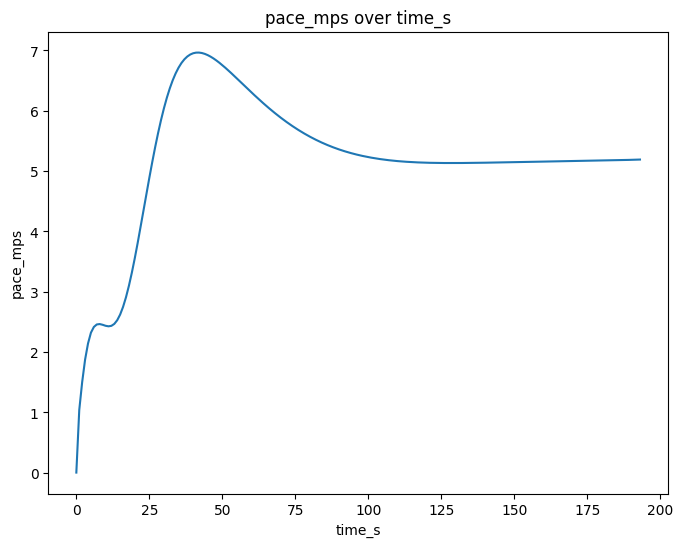

In [107]:
import matplotlib.pyplot as plt
# Plot pace over time
# x_label = 'distance_m'
x_label = 'time_s'
# y_label = 'distance_m'
y_label = 'pace_mps'
# y_label = 'diff_pace_mps2'
# y_label = 'heartrate_bps'
plt.figure(figsize=(8, 6))
plt.plot(data[x_label], data[y_label])
plt.title(f'{y_label} over {x_label}')
plt.xlabel(f'{x_label}')
plt.ylabel(f'{y_label}')
plt.show()
